In [1]:
import pandas
import numpy as np
from utils import *
import mne
import matplotlib.pyplot as plt
from os import walk
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import normalize, StandardScaler
from itertools import combinations

def get_psd(raw, n_fft=None, filter=None, returnMean=False):
    raw_copy = raw.copy()
    if(filter != None):
        raw_copy.filter(filter[0],filter[1], verbose=False)
    if(n_fft == None):
        psd, freq = mne.time_frequency.psd_welch(raw_copy,n_fft = raw_copy.data.shape[1], verbose=False)
    else:
        psd, freq = mne.time_frequency.psd_welch(raw_copy,n_fft = n_fft, verbose=False)
    psd = 10 * np.log10(psd)
    if(returnMean):
        psd = psd.mean(axis=1)
        if(np.any(np.isnan(psd))):
            raise ValueError(f"value NaN: {psd}")
        if(np.all(np.isfinite(psd)) == False):
            raise ValueError(f"value inifinit: {psd}")
    mean = psd.mean(0)
    std = psd.std(0)
    return psd, freq, mean, std

def get_epoch(raw, verbose=False):
    raw_copy = raw.copy()
    events = mne.find_events(raw_copy, stim_channel='Marker', initial_event=True, verbose=verbose)
    if(len(events) != 5):
        raise ValueError(f"The event is missing. Number of event not equal to 5 ({len(events)}).\n {events}")
    epochs = mne.Epochs(raw_copy, events, tmin=0.3, tmax=5.5, baseline=(0.3,0.3), verbose=verbose)
    if(epochs.get_data().shape[0] != 5):
        raise ValueError(f"There might be a bad data. epochs.get_data().shape = {epochs.get_data().shape}")
    return epochs

def plot_psd(raw):
    psd, freq, mean, std = get_psd(raw)
    fig, ax = plt.subplots(figsize=(10,5))
    for i in range(8):
        ax.plot(freq,psd[i] ,label=raw.info['ch_names'][i], lw=1, alpha=0.6)
    ax.fill_between(250//2, mean - std, mean + std, color='k', alpha=.5)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Amplitube (dBV)')
    ax.set_title('EEG of ')
    ax.legend()
    plt.show()

## Groud Truth

In [2]:
plt.style.use('seaborn-whitegrid')

df = pandas.read_csv('./HEXACO.csv')
# Honesty-Humility	Emotionality	eXtraversion	Agreeableness	Conscientiousness	Openness to Experience
gt = df[['id','Honesty-Humility','Emotionality','eXtraversion','Agreeableness','Conscientiousness','Openness to Experience']].rename(columns={'Honesty-Humility':'h',
                                  'Emotionality':'e',
                                  'eXtraversion':'x',
                                 'Agreeableness':'a',
                             'Conscientiousness':'c',
                        'Openness to Experience':'o'}).set_index('id')
labels = []
for i in gt.index:
    # print(gt.loc[i], np.argmax(gt[['h','e','x','a','c','o']].loc[i]))
    labels.append(np.argmax(gt[['h','e','x','a','c','o']].loc[i]))
gt['label'] = labels
gt

,h,e,x,a,c,o,label
id,,,,,,,
2,3.63,3.19,2.94,2.38,3.38,2.38,0
3,3.38,3.44,3.50,3.50,4.50,3.81,4
4,3.19,3.75,3.69,3.19,2.63,2.63,1
5,3.25,3.63,2.13,3.56,3.63,2.31,1
6,3.25,2.75,3.50,2.50,3.75,5.00,5
7,4.06,3.06,3.38,2.88,2.50,4.19,5
8,3.94,2.94,3.19,3.75,3.38,3.81,0
9,4.44,4.00,3.38,3.75,3.69,3.31,0
10,3.63,3.25,3.50,3.31,3.88,2.69,4


## EEG Data

In [3]:
path, folders, filenames = next(walk('./data'))
print(filenames)

['29-audio.csv', '5-audio.csv', '10-audio.csv', '17-audio.csv', '10-image.csv', '14-audio.csv', '33-audio.csv', '31-audio.csv', '9-audio.csv', '20-audio.csv', '6-audio.csv', '13-image.csv', '25-image.csv', '5-image.csv', '14-image.csv', '22-image.csv', '7-image.csv', '23-audio.csv', '28-image.csv', '15-audio.csv', '25-audio.csv', '32-audio.csv', '21-image.csv', '23-image.csv', '2-audio.csv', '36-audio.csv', '26-audio.csv', '12-audio.csv', '3-image.csv', '2-image.csv', '35-image.csv', '12-image.csv', '30-image.csv', '36-image.csv', '27-audio.csv', '15-image.csv', '32-image.csv', '26-image.csv', '8-audio.csv', '34-image.csv', '8-image.csv', '20-image.csv', '9-image.csv', '3-audio.csv', '35-audio.csv', '16-audio.csv', '22-audio.csv', '17-image.csv', '7-audio.csv', '11-audio.csv', '18-image.csv', '27-image.csv', '29-image.csv', '13-audio.csv', '6-image.csv', '30-audio.csv', '21-audio.csv', '31-image.csv', '33-image.csv', '34-audio.csv', '28-audio.csv', '11-image.csv', '16-image.csv', '18-a

In [4]:
gt.drop([11,4,36],inplace=True)

filenames.remove('11-audio.csv')
filenames.remove('11-image.csv')

filenames.remove('36-audio.csv')
filenames.remove('36-image.csv')

In [5]:
path = './data'
columns = {'Unnamed: 1':'Fp1',
        'Unnamed: 2':'Fp2',
        'Unnamed: 3':'F3',
        'Unnamed: 4':'F4',
        'Unnamed: 5':'F7',
        'Unnamed: 6':'F8',
        'Unnamed: 7':'P7',
        'Unnamed: 8':'P8'}

EEG_audio, EEG_image = dict(), dict()
from itertools import product
categories = [1,2,3,4,5]
blocks = [1,2]
for filename in filenames:
    participant_id, stimuli = filename.split('-')
    stimuli = stimuli.rstrip('.csv')
    data = pandas.read_csv(f'{path}/{filename}', dtype={'Marker': str}).rename(columns=columns).drop(columns='timestamps')
    print(participant_id, stimuli)
    # experiment = dict()
    # for (category, block) in product(categories,blocks):
        # print("   ", category, block)
        # section = get_section_from_catblock(data, category=category,block=block)
        # experiment[f"{category}_{block}"] = section
    if(stimuli == 'audio'):
        EEG_audio[int(participant_id)] = data
    elif(stimuli == 'image'):
        EEG_image[int(participant_id)] = data
    else:
        raise ValueError(f"Stimuli:{stimuli} is unexpected.")

29 audio
5 audio
10 audio
17 audio
10 image
14 audio
33 audio
31 audio
9 audio
20 audio
6 audio
13 image
25 image
5 image
14 image
22 image
7 image
23 audio
28 image
15 audio
25 audio
32 audio
21 image
23 image
2 audio
26 audio
12 audio
3 image
2 image
35 image
12 image
30 image
27 audio
15 image
32 image
26 image
8 audio
34 image
8 image
20 image
9 image
3 audio
35 audio
16 audio
22 audio
17 image
7 audio
18 image
27 image
29 image
13 audio
6 image
30 audio
21 audio
31 image
33 image
34 audio
28 audio
16 image
18 audio


In [19]:
def get_data(n_fft = None, eeg_type = 'image', bands = [0,1,2,3,4]):
    X = None
    y = []
    # Gamma BETA ALPHA THETA DELTA
    # filter_list = [[30,None],[13,30],[8,12],[4,8],[None,4]]
    # https://reader.elsevier.com/reader/sd/pii/S0957417410005695?token=99F7CC487CECF9C17E36713347D0F8372A289AC2C6331A2B6C4F272CD34921FD8B418EB417C0F9C3796CEA271FB4455D&originRegion=eu-west-1&originCreation=20210510142445
    # sub-band frequenciesd(1–4 Hz),h(4–8 Hz),a(8–13 Hz) andb(13–30 Hz)
    filter_list = [[30,None],[13,30],[8,13],[4,8],[1,4]]
    # ids = [33,2,10,12,16]
    ids = gt.index.tolist()
    for id in ids:
        # print('\n',"="*20,id)
        if(eeg_type == 'image'):
            raw = dataframe_to_raw(EEG_image[id], sfreq=250)
        else:
            raw = dataframe_to_raw(EEG_audio[id], sfreq=250)
        raw.notch_filter([50,100],filter_length='auto', phase='zero', verbose=False) # Line power
        raw.filter(1., None, fir_design='firwin', verbose=False) # Slow drift
        events = mne.find_events(raw, stim_channel='Marker', initial_event=True, verbose=False)
        events = np.delete(events,np.argwhere(events[:,2] == 1), axis=0)
        if(events.shape[0] != 50):
            raise ValueError(f"Event missing: {events[:,2]}. len(events.shape[0])={events.shape[0]}")
        epochs = mne.Epochs(raw, events, tmin=0.3, tmax=5.8, baseline=(0.3,0.3), verbose=False)
        if(epochs.get_data().shape[0] != 50):
            raise ValueError(f"There might be a bad data. epochs.get_data().shape = {epochs.get_data().shape}")
        for epoch in epochs.iter_evoked():
            features = None
            for band in bands:
                # print(epoch.data.shape)
                psd,_,_,_ = get_psd(epoch, n_fft = n_fft, filter=filter_list[band], returnMean=True)
                # print(type(features))
                if(type(features) == type(None)):  features = np.expand_dims(psd,axis=0)
                else:  features = np.concatenate([features,np.expand_dims(psd,axis=0)], axis=1)
                # features.append(psd)
                # print(psd,filter_list[band])
                # print(features.shape)
            # features = np.mean(features, axis=1)
            # print("feature shape:", features.shape)
            if(type(X) == type(None)): X = features#np.expand_dims(features,axis=0)
            else: X = np.concatenate( [X, features ], axis=0 )
            # X.append(np.array(features).reshape(-1))
            # print("X:", X.shape)
            y.append(gt.loc[id]['label'])
        # break
    # X = np.array(X)#.reshape(len(ids),-1)
    y = np.array(y)
    return X,y
# X,y = get_data()

def get_acc(X,y):
    X_copy = X.copy()
    X_norm = normalize(X_copy, axis=0)
    
    gnb = GaussianNB()
    gnb.fit(X_norm, y)  
    pred = gnb.predict(X_norm)
    acc = sum(y == pred)/len(y)
    return acc

from mne.time_frequency import tfr_morlet
def get_data_wt(eeg_type = 'image'):
    X = None
    y = []
    filter_list = np.array([4,8,13,30,125])
    # ids = [33,2,10,12,16]
    ids = gt.index.tolist()
    for id in ids:
        # print('\n',"="*20,id)
        if(eeg_type == 'image'):
            raw = dataframe_to_raw(EEG_image[id], sfreq=250)
        else:
            raw = dataframe_to_raw(EEG_audio[id], sfreq=250)
        raw.notch_filter([50,100],filter_length='auto', phase='zero', verbose=False) # Line power
        raw.filter(1., None, fir_design='firwin', verbose=False) # Slow drift
        events = mne.find_events(raw, stim_channel='Marker', initial_event=True, verbose=False)
        events = np.delete(events,np.argwhere(events[:,2] == 1), axis=0)
        if(events.shape[0] != 50):
            raise ValueError(f"Event missing: {events[:,2]}. len(events.shape[0])={events.shape[0]}")
        epochs = mne.Epochs(raw, events, tmin=0.3, tmax=5.8, baseline=(0.3,0.3), verbose=False)
        if(epochs.get_data().shape[0] != 50):
            raise ValueError(f"There might be a bad data. epochs.get_data().shape = {epochs.get_data().shape}")

        for epoch in epochs.iter_evoked():
            features = None
            for band in bands:
                # print(epoch.data.shape)
                psd,_,_,_ = get_psd(epoch, n_fft = n_fft, filter=filter_list[band], returnMean=True)
                # print(type(features))
                if(type(features) == type(None)):  features = np.expand_dims(psd,axis=0)
                else:  features = np.concatenate([features,np.expand_dims(psd,axis=0)], axis=1)
                # features.append(psd)
                # print(psd,filter_list[band])
                # print(features.shape)
            # features = np.mean(features, axis=1)
            # print("feature shape:", features.shape)
            if(type(X) == type(None)): X = features#np.expand_dims(features,axis=0)
            else: X = np.concatenate( [X, features ], axis=0 )
            # X.append(np.array(features).reshape(-1))
            # print("X:", X.shape)
            y.append(gt.loc[id]['label'])
        # break
    # X = np.array(X)#.reshape(len(ids),-1)
    y = np.array(y)
    return X,y

In [28]:
raw = dataframe_to_raw(EEG_image[33], sfreq=250)
raw.notch_filter([50,100],filter_length='auto', phase='zero', verbose=False) # Line power
raw.filter(1., None, fir_design='firwin', verbose=False) # Slow drift
events = mne.find_events(raw, stim_channel='Marker', initial_event=True, verbose=False)
events = np.delete(events,np.argwhere(events[:,2] == 1), axis=0)
if(events.shape[0] != 50):
    raise ValueError(f"Event missing: {events[:,2]}. len(events.shape[0])={events.shape[0]}")
epochs = mne.Epochs(raw, events, tmin=0.3, tmax=5.8, baseline=(0.3,0.3), verbose=False)

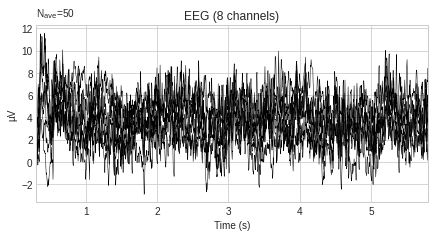

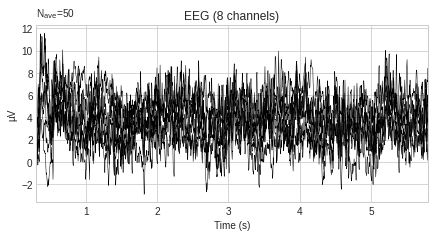

In [29]:
epochs.average().plot()

In [59]:
# [[30,None],[13,30],[8,13],[4,8],[1,4]]
# freqs = np.arange(5., 100., 3.)
freqs = np.array([4,8,13,30,125])
vmin, vmax = -3., 3.  # Define our color limits.

In [60]:
freqs /2.

array([ 2. ,  4. ,  6.5, 15. , 62.5])

In [61]:
from mne.time_frequency import tfr_morlet
n_cycles = freqs / 2.
power = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, return_itc=False, average=False)

Not setting metadata


In [62]:
# datandarray, shape (n_epochs, n_channels, n_freqs, n_times)
power.data.shape

(50, 8, 5, 1376)

In [66]:
np.mean(power.data, axis=3)

(50, 8, 5)

<class 'mne.time_frequency.tfr.EpochsTFR'>
No baseline correction applied


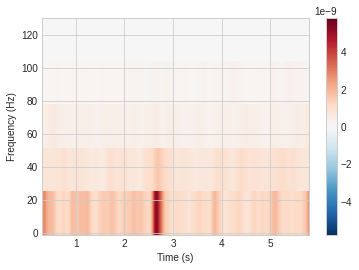

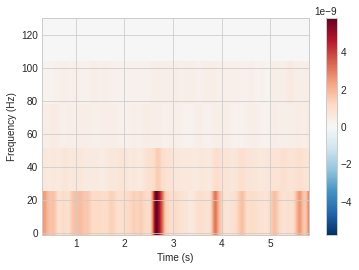

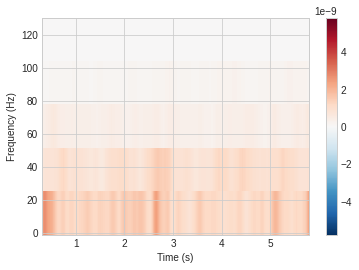

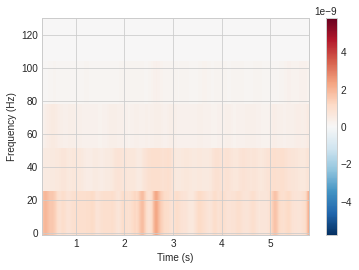

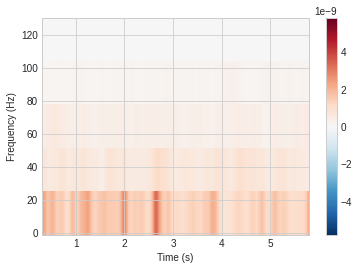

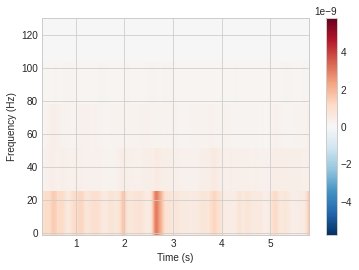

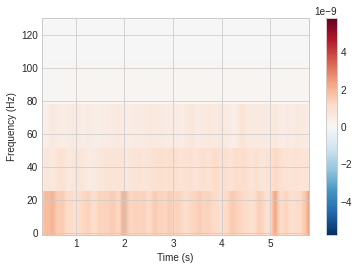

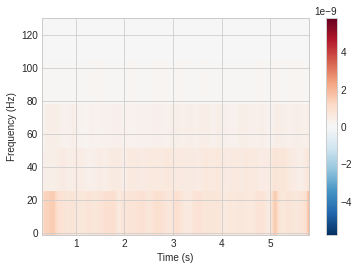

[<Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>]

In [64]:
print(type(power))
avgpower = power.average()
avgpower.plot()

In [7]:
import warnings
warnings.filterwarnings("ignore")
band_name = np.array(['Gamma','BETA','ALPHA','THETA','DELTA'])

In [20]:
n_fft = 128
bands = [0,1,2,3,4]
for eeg_type in ['image','audio']:
    print(f"==== {eeg_type} ====")
    X,y = get_data(n_fft=n_fft,eeg_type = eeg_type, bands = [1,2,3,4])
    acc = get_acc(X,y)
    print(f"{list(band_name[bands])}:{acc}")

==== image ====
<Evoked | '0.02 × 111 + 0.02 × 112 + 0.02 × 113 + 0.02 × 114 + 0.02 × 115 + 0.02 × 121 + 0.02 × 122 + 0.02 × 123 + 0.02 × 124 + 0.02 × 125 + 0.02 × 211 + 0.02 × 212 + 0.02 × 213 + 0.02 × 214 + 0.02 × 215 + 0.02 × 221 + 0.02 × 222 + 0.02 × 223 + 0.02 × 224 + 0.02 × 225 + 0.02 × 311 + 0.02 × 312 + 0.02 × 313 + 0.02 × 314 + 0.02 × 315 + 0.02 × 321 + 0.02 × 322 + 0.02 × 323 + 0.02 × 324 + 0.02 × 325 + 0.02 × 411 + 0.02 × 412 + 0.02 × 413 + 0.02 × 414 + 0.02 × 415 + 0.02 × 421 + 0.02 × 422 + 0.02 × 423 + 0.02 × 424 + 0.02 × 425 + 0.02 × 511 + 0.02 × 512 + 0.02 × 513 + 0.02 × 514 + 0.02 × 515 + 0.02 × 521 + 0.02 × 522 + 0.02 × 523 + 0.02 × 524 + 0.02 × 525' (average, N=50), 0.3 – 5.8 sec, baseline 0.3 – 0.3 sec, 8 ch, ~103 kB>


TypeError: 'EvokedArray' object is not iterable

In [10]:
X.shape

(1500, 32)

In [ ]:
X,y = get_data(n_fft=128,eeg_type = 'image')

In [ ]:
# remove slow drift + psd_welch(n_fft=128)
for n_fft in [2,4,8,16,32,64,128,256,512,1024,None]:
    for eeg_type in ['image','audio']:
        print(f"==== {eeg_type}|nfft={n_fft} ====")
        X,y = get_data(n_fft=n_fft,eeg_type = eeg_type)
        for pre in ['norm',' std']:
            acc = get_acc(X,y, pre=pre)
            print(f"{pre}:{list(band_name)}:{acc}")

## Grid Search

In [ ]:
import warnings
warnings.filterwarnings("ignore")
band_name = np.array(['Gamma','BETA','ALPHA','THETA','DELTA'])

In [ ]:
for eeg_type in ['image','audio']:
    print(f"==== {eeg_type} ====")
    for index, comb in enumerate( list(combinations([0,1,2,3,4],1)) ):
        X,y = get_data(eeg_type,comb)
        acc = get_acc(X,y)
        print(f"{list(band_name[list(comb)])}:{acc}")

In [ ]:
for eeg_type in ['image','audio']:
    print(f"==== {eeg_type} ====")
    for index, comb in enumerate( list(combinations([0,1,2,3,4],2)) ):
        X,y = get_data(eeg_type,comb)
        acc = get_acc(X,y)
        print(f"{list(band_name[list(comb)])}:{acc}")

In [ ]:
for eeg_type in ['image','audio']:
    print(f"==== {eeg_type} ====")
    for index, comb in enumerate( list(combinations([0,1,2,3,4],3)) ):
        X,y = get_data(eeg_type,comb)
        acc = get_acc(X,y)
        print(f"{list(band_name[list(comb)])}:{acc}")

In [ ]:
for eeg_type in ['image','audio']:
    print(f"==== {eeg_type} ====")
    for index, comb in enumerate( list(combinations([0,1,2,3,4],4)) ):
        X,y = get_data(eeg_type,comb)
        acc = get_acc(X,y)
        print(f"{list(band_name[list(comb)])}:{acc}")

In [ ]:
for eeg_type in ['image','audio']:
    print(f"==== {eeg_type} ====")
    for index, comb in enumerate( list(combinations([0,1,2,3,4],5)) ):
        X,y = get_data(eeg_type,comb)
        acc = get_acc(X,y)
        print(f"{list(band_name[list(comb)])}:{acc}")

# Plotting

In [ ]:
# raw = dataframe_to_raw(EEG_image[33], sfreq=250)
# raw.notch_filter([50,100])

In [ ]:
# raw.plot_psd()

In [ ]:
# from sklearn import preprocessing
# fig, ax = plt.subplots(2, figsize=(30,9))

# df = raw.to_data_frame()
# time = np.arange(0,len(df)/250, 1/250)

# for i,col in enumerate(['Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'P7', 'P8']):
#     ax[0].plot(time,df[col], label=col)
# ax[0].set_xlabel('time (second)')
# ax[0].set_ylabel('Voltage (uV)')
# ax[0].set_title('Original EEG')
# ax[0].legend()

# x = df.values #returns a numpy array
# min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)
# df = pd.DataFrame(x_scaled)

# for i,col in enumerate(['Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'P7', 'P8']):
#     # ax.plot(time,df[col], label=col)
#     ax[1].plot(time,df[i+1], label=col)
# ax[1].set_xlabel('time (second)')
# ax[1].set_ylabel('Normalized Voltage')
# ax[1].set_title('Normalized EEG')
# ax[1].legend()